This tutorial covers creating MDPs using the segar library. Theoretically,
what is implemented in SEGAR is a POMDP, which has the form:

$T =  \langle \mathcal{S}, \mathcal{A}, \mathcal{P}, \mathcal{R},
\mathcal{O}, \mathcal{Z}, s_0\rangle$, where:
* $\mathcal{S}$ is a state space,
* $\mathcal{A}$ is an action space,
* $\mathcal{P}: \mathcal{S} \times  \mathcal{A} \times \mathcal{S} \to [0,
1]$ is a transition function  characterizing environment dynamics
(controlled by our simulator),
* $\mathcal{R}: \mathcal{S} \times \mathcal{A} \to \mathbb{R}$ is a reward
 function,
* $\mathcal{O}$ is the observation space,
* $\mathcal{Z}: \mathcal{S} \times \mathcal{O} \to [0, 1]$ is an observation
 function, and
* $s_0 \in \mathcal{S}$ is an initial state.

For simplicity we will refer to this as an "MDP". In practical terms, we have
split the MDP into the following functional components:

* __Simulator object__(`segar.sim.core.Simulator`) controls the underlying
state space $\mathcal{S}$ and the transition function $\mathcal{P}$.
* __Observations objects__(`segar.mdps.observations.Observations`), make up
the observation function and corresponding space $(\mathcal{Z}, \mathcal{O})$.
* __Task objects__(`segar.mdps.tasks.Task`) control the initialization $s_0$
(`segar.mdps.initializations.Initialization`), the reward $\mathcal{R}$, and
the actions $\mathcal{A}$. The task also embodies the semantics of the MDP,
controlling what states correspond to reward, what observations the agent
sees, etc.
* __MDP objects__ put this all together and coordinate all of the components.

For the simulator object, please see `segar.sim.README.md` for a tutorial.
This tutorial covers the remaining components.

## Observations
Observations control what the agent sees to determine its actions. This is
provided by the Observations objects:


In [1]:
import numpy as np
import pprint

from segar.configs.handler import get_env_config
from segar.mdps.observations import RGBObservation
from segar.sim import Simulator
from segar.factors import *


pp = pprint.PrettyPrinter(indent=4)

sim = Simulator()
sim.add_ball(position=np.array([0.05, 0.05]), text='X',
             initial_factors={Charge: -0.5})
sim.add_magnet(position=np.array([-0.5, 0.5]), text='M',
               initial_factors={Size: 0.3, Mobile: True})
sim.add_sand(position=np.array([0.1, -0.1]), text='S',
             initial_factors={Shape: Hexagon(0.4)})
sim.add_magma(position=np.array([-0.5, 0.5]), text='G',
              initial_factors={Shape: Square(0.8)})
sim.add_charger(position=np.array([0.3, 0.7]), text='C',
                initial_factors={Charge: 1.0, Mobile: True})

visual_config = get_env_config('visual', 'linear_ae', dist_name='baseline')

rgb_obs = RGBObservation(resolution=256, config=visual_config, annotation=True)

`RGBObservations` render the states into pixels, default using a generative
model of visual features provided by the repo. See `segar/rendering/README.md`
for more details.

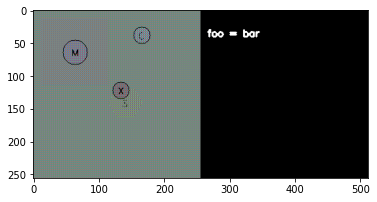

In [2]:
from matplotlib.pyplot import imshow
import PIL

rgb_obs.reset()
img_arr = rgb_obs.render(results=dict(foo='bar'))
image = PIL.Image.fromarray(img_arr)
imshow(image)

Note that we can pass results to the renderer for human readability. This rendered uses annotations, but we can omit them, which would be what the agent would see:

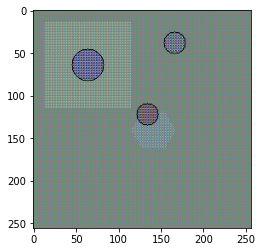

In [3]:
rgb_obs_no_ann = RGBObservation(resolution=256, config=visual_config, annotation=False)
rgb_obs_no_ann.reset()
img_arr = rgb_obs_no_ann.render()
image = PIL.Image.fromarray(img_arr)
imshow(image)

`ObjectStateObservation` and `TileStateObservation` however need unique ids to
reference which state should be used to generate observations:

In [4]:
from segar.mdps.observations import ObjectStateObservation, TileStateObservation

sim.reset()  # Resets the simulator.

sim.add_ball(position=np.array([0.05, 0.05]), text='O', unique_id='tennis_ball',
             initial_factors={Charge: -0.5})
sim.add_sand(position=np.array([0.1, -0.1]), text='S', initial_factors={ID: 'sand_pit', Shape: Hexagon(0.5)})

obj_obs = ObjectStateObservation('tennis_ball')
tile_obs = TileStateObservation('sand_pit')
pp.pprint(obj_obs(sim.state))
pp.pprint(tile_obs(sim.state))

array([-0.5 ,  1.  ,  0.  ,  0.  ,  0.05,  0.05,  0.  ,  0.  ,  0.  ,
        0.  ,  1.  ,  0.  ])
array([ 0. ,  0.4,  0.1, -0.1])


Because we might be interested in experiments that evaluate the ability of
agents to understand the factors from dynamics, we can also construct
observation spaces that hide certain factors:

In [5]:
obj_obs_no_mass = ObjectStateObservation(
    'tennis_ball', filter_factors=[Mass])

pp.pprint(obj_obs_no_mass(sim.state))

array([-0.5 ,  0.  ,  0.  ,  0.05,  0.05,  0.  ,  0.  ,  0.  ,  0.  ,
        1.  ,  0.  ])


Similarly we can filter visual features:

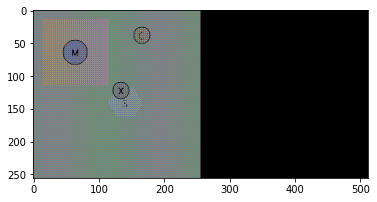

In [6]:
sim.reset()
sim.add_ball(position=np.array([0.05, 0.05]), text='X',
             initial_factors={Charge: -0.5}, unique_id='tennis_ball')
sim.add_magnet(position=np.array([-0.5, 0.5]), text='M',
               initial_factors={Size: 0.3, Mobile: True})
sim.add_sand(position=np.array([0.1, -0.1]), text='S',
             initial_factors={Shape: Hexagon(0.4)}, unique_id='sand_pit')
sim.add_magma(position=np.array([-0.5, 0.5]), text='G',
              initial_factors={Shape: Square(0.8)})
sim.add_charger(position=np.array([0.3, 0.7]), text='C',
                initial_factors={Charge: 1.0, Mobile: True})

rgb_obs_no_heat = RGBObservation(resolution=256, config=visual_config,
                                 filter_factors=[Heat], annotation=True)
rgb_obs_no_heat.reset()
img_arr = rgb_obs_no_heat.render()
image = PIL.Image.fromarray(img_arr)
imshow(image)

Note that the heat visual features are gone, and now we can only see random
visual features present in all objects and tiles. See the rendering tutorial
 for more details.

We can combine the observation spaces using `MultimodalObservation`.

In [7]:
from segar.mdps.observations import MultimodalObservation
mm_obs = MultimodalObservation(obj_obs, tile_obs)
pp.pprint(mm_obs(sim.state))

(   array([-0.5 ,  1.  ,  0.  ,  0.  ,  0.05,  0.05,  0.  ,  0.  ,  0.  ,
        0.  ,  1.  ,  0.  ]),
    array([ 0. ,  0.4,  0.1, -0.1]))


`AllObjectsStateObservation` and `AllTilesStateObservation` collect
 all states of either objects or tiles. `unique_ids` can be passed to give
 fixed positions to certain objects or tiles.

In [8]:
from segar.mdps.observations import AllObjectsStateObservation
sim.add_ball(position=np.array([0.5, 0.5]), text='X', initial_factors={Charge: -0.7, Magnetism: 0.1,
             Mass: 0.5})
sim.add_magnet(position=np.array([-0.5, 0.5]), text='M', initial_factors={Mobile: True, Mass: 0.1})

all_obj_obs = AllObjectsStateObservation(n_things=10,
                                         unique_ids=['tennis_ball'])

obs = all_obj_obs(sim.state)
pp.pprint(obs)

array([[-0.5 ,  1.  ,  0.  ,  0.  ,  0.05,  0.05,  0.  ,  0.  ,  0.  ,
         0.  ,  1.  ,  0.  ],
       [ 0.  ,  1.  ,  1.  ,  0.  , -0.5 ,  0.5 ,  0.  ,  0.  ,  0.  ,
         0.  ,  1.  ,  0.  ],
       [ 1.  ,  1.  ,  0.  ,  0.  ,  0.3 ,  0.7 ,  0.  ,  0.  ,  0.  ,
         0.  ,  1.  ,  0.  ],
       [-0.7 ,  0.5 ,  0.1 ,  0.  ,  0.5 ,  0.5 ,  0.  ,  0.  ,  0.  ,
         0.  ,  1.  ,  0.  ],
       [ 0.  ,  0.1 ,  1.  ,  0.  , -0.5 ,  0.5 ,  0.  ,  0.  ,  0.  ,
         0.  ,  1.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  

Finally, we can create stacked observations. The simulator needs to be
initialized with a state buffer, though. Also, when in use with
multimodal observations, do not stack the mutlimodal observations: make a
multimodal observation from stacked ones.

In [9]:
from segar.mdps.observations import make_stacked_observation

sim = Simulator(state_buffer_length=10)
sim.add_ball(position=np.array([0.5, 0.5]), text='X', unique_id='tennis_ball', 
             initial_factors={Charge: -0.7, Magnetism: 0.1, Mass: 0.5})
sim.add_magnet(position=np.array([-0.5, 0.5]), text='M', initial_factors={Mobile: True, Mass: 0.1})

all_obj_obs = AllObjectsStateObservation(n_things=10,
                                         unique_ids=['tennis_ball'])

StackedAllObjObs = make_stacked_observation(AllObjectsStateObservation,
                                            n_stack=4)

stacked_all_obj_obs = StackedAllObjObs(n_things=10,
                                       unique_ids=['tennis_ball'])

for _ in range(5):
    sim.step()

stacked_obs = stacked_all_obj_obs(sim.state)
obs = all_obj_obs(sim.state)

print(obs.shape, stacked_obs.shape)

(10, 12) (4, 10, 12)


## Tasks

Tasks control initialization, reward, and actions. However, the
initialization function itself is complex, as it involves control over what
is placed in the arena and where, what the factors are, etc.

`segar.mdps.initializations.ArenaInitialization` is a convenient class for
initializing environments for tasks. A configuration is used to construct
the initialization object. For more details on configurations, see
`segar/configs/README.md`.

In [17]:
from segar.sim.location_priors import RandomMiddleLocation, RandomEdgeLocation
from segar.things import *
from segar.rules import Prior
from segar.mdps.initializations import ArenaInitialization

object_factory = ThingFactory([Charger, Magnet, Bumper, Damper, Ball])
tile_factory = ThingFactory({SandTile: 2. / 5, MagmaTile: 1. / 5, FireTile: 1. / 5, Hole: 1. / 5})

config = dict(
    numbers=
        [(object_factory, DiscreteRangeNoise(1, 3)),
         (tile_factory, DiscreteRangeNoise(1, 3))],
    
    priors=
        [
            Prior(Position, RandomMiddleLocation(), entity_type=Tile),
            Prior(Position, RandomEdgeLocation(), entity_type=Object),
            Prior(Shape, Circle(0.2), entity_type=Object),
            Prior(Shape, RandomConvexHull(0.3), entity_type=Tile),
            Prior(Shape, Circle(0.4), entity_type=Hole),
            Prior(Mass, 1.0, entity_type=Object),
            Prior(Mobile, True),
            Prior(Charge, GaussianMixtureNoise(means=[-1., 1.], stds=[0.1, 0.1]), entity_type=Charger),
            Prior(Magnetism, GaussianMixtureNoise(means=[-1., 1.], stds=[0.1, 0.1]), entity_type=Magnet),
            Prior(Friction, UniformNoise(0.2, 1.0), entity_type=SandTile)
         ]    
)

initialization = ArenaInitialization(config=config)

Now that the initialization is set up, we can construct our Task object:

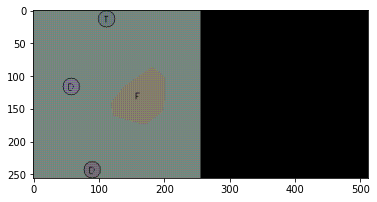

In [18]:
from segar.mdps.tasks import Task

sim.reset()

class MyTask(Task):

    def check_action(self, action):
        assert isinstance(action, np.ndarray) and action.shape == (2,)

    def apply_action(self, action):
        # Just apply force to first thing that has Velocity.
        idx = self.sim.thing_ids_with_factor(Velocity)[0]
        self.sim.add_force(idx, action)

    def demo_action(self):
        return np.random.normal() + np.array((2, 1.5))

    def reward(self, state):
        idx = self.sim.thing_ids_with_factor(Velocity)[0] 
        # Just see if the first object is alive.
        return float(state['things'][idx][Alive])

    def done(self, state):
        idxs = self.sim.thing_ids_with_factor(Velocity)
        object_states = dict((idx, state['things'][idx]) for idx in idxs)
        done = False
        for state in object_states.values():
            if not state[Alive] or state[Done]:
                done = True

        return done

action_range = [-100, 100]  # Range of valid action values
action_shape = (2,)  # 2d vectors
action_type = np.float32
baseline_action = np.zeros(2).astype(np.float32)

task = MyTask(action_range=action_range, action_shape=action_shape,
              action_type=action_type, baseline_action=baseline_action,
              initialization=initialization)

task.sample()  # Samples from the initialization.
task.initialize()  # Spawns objects.
rgb_obs.reset()
img_arr = rgb_obs.render()
image = PIL.Image.fromarray(img_arr)
imshow(image)

There is additional functionality in the task and initialization to track
the semantics of objects and tiles. For examples, see `segar/tasks/README.md`.

## The MDP

We can do quite a bit with the task object alone, but it is more convenient
to use the MDP, which puts everything together. The MDP is built from the
gym3 environment, so it is usable as such. Here we will simply construct the
 MDP and demonstrate some of its features.

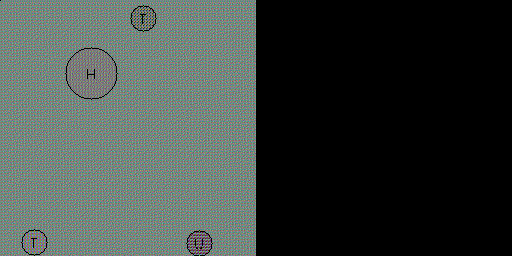

In [19]:
from IPython.display import Image

from segar.mdps.mdps import MDP
from segar.tools.sample_trajectories import save_gif

mdp = MDP(rgb_obs, task)
mdp.reset()

trajectory = []

def render_observation():
    obs = rgb_obs.render()
    trajectory.append(obs.copy())

render_observation()

action = task.demo_action()  # Take an initial action
done = False
while not done:
    _, _, done, _ = mdp.step(action)
    action = np.array((0., 0.))  # There's no "agent" so do nothing.
    render_observation()

save_gif(trajectory, out_path=f'{ASSET_DIR}//trajectory_sample.gif')
Image(open('_ipynb_assets/trajectory_sample.gif','rb').read())